In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from corner import corner
import scipy.stats
import emcee
from scipy.optimize import fmin

In [2]:
n = 50
μ = 4.5
σ = 0.3
θ = μ, σ

X = scipy.stats.norm(μ, σ).rvs(n)
X.mean(), X.std(ddof=1)

(4.590281543410609, 0.28556095619706556)

In [3]:
def log_prior(θ):
    μ, σ = θ
    if σ > 0:
        return 0
    else:
        return -np.inf
    
def log_likelihood(θ, X):
    μ, σ = θ
    return scipy.stats.norm(μ, σ).logpdf(X).sum()

def log_posterior(θ, X):
    logpri = log_prior(θ)
    if np.isinf(logpri):
        return logpri
    return logpri + log_likelihood(θ, X)

log_prior((μ, σ)), log_likelihood((μ, σ), X), log_posterior((μ, σ), X)

(0, -10.210762996909219, -10.210762996909219)

In [4]:
mle = fmin(lambda θ: -log_likelihood(θ, X), [1,1])
print(mle)
print(θ)

Optimization terminated successfully.
         Current function value: 7.776871
         Iterations: 57
         Function evaluations: 106
[4.59027673 0.28272035]
(4.5, 0.3)


In [11]:
def fit(X, ret_sampler=False):
    sampler = emcee.EnsembleSampler(25, 2, log_posterior, args=[X])
    mle = fmin(lambda θ: -log_likelihood(θ, X), [1,1], disp=0)
    guesses = scipy.stats.norm(mle, mle/2).rvs((25,2))
    sampler.run_mcmc(guesses, 150)
    sample = sampler.chain[:, 75:, :].reshape(-1, 2)
    return sampler if ret_sampler else sample

def inv_cdf(sample, θ):
    return [(sample[:,i] < θ[i]).mean() for i in range(len(θ))]

In [15]:
sampler = fit(X, ret_sampler=True)

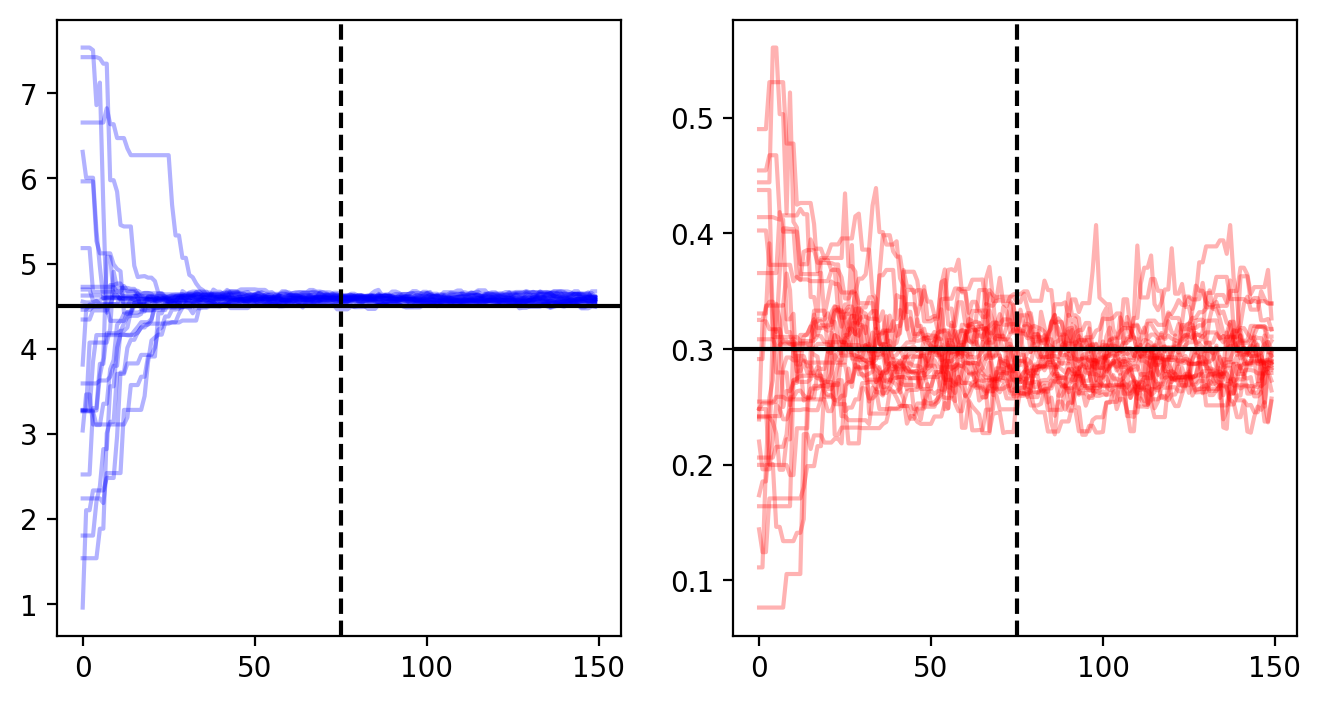

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(sampler.chain[:,:,i].T, alpha=0.3, color=['blue', 'red'][i])
    ax.axhline(θ[i], color='k')
    ax.axvline(75, color='k', ls='--');

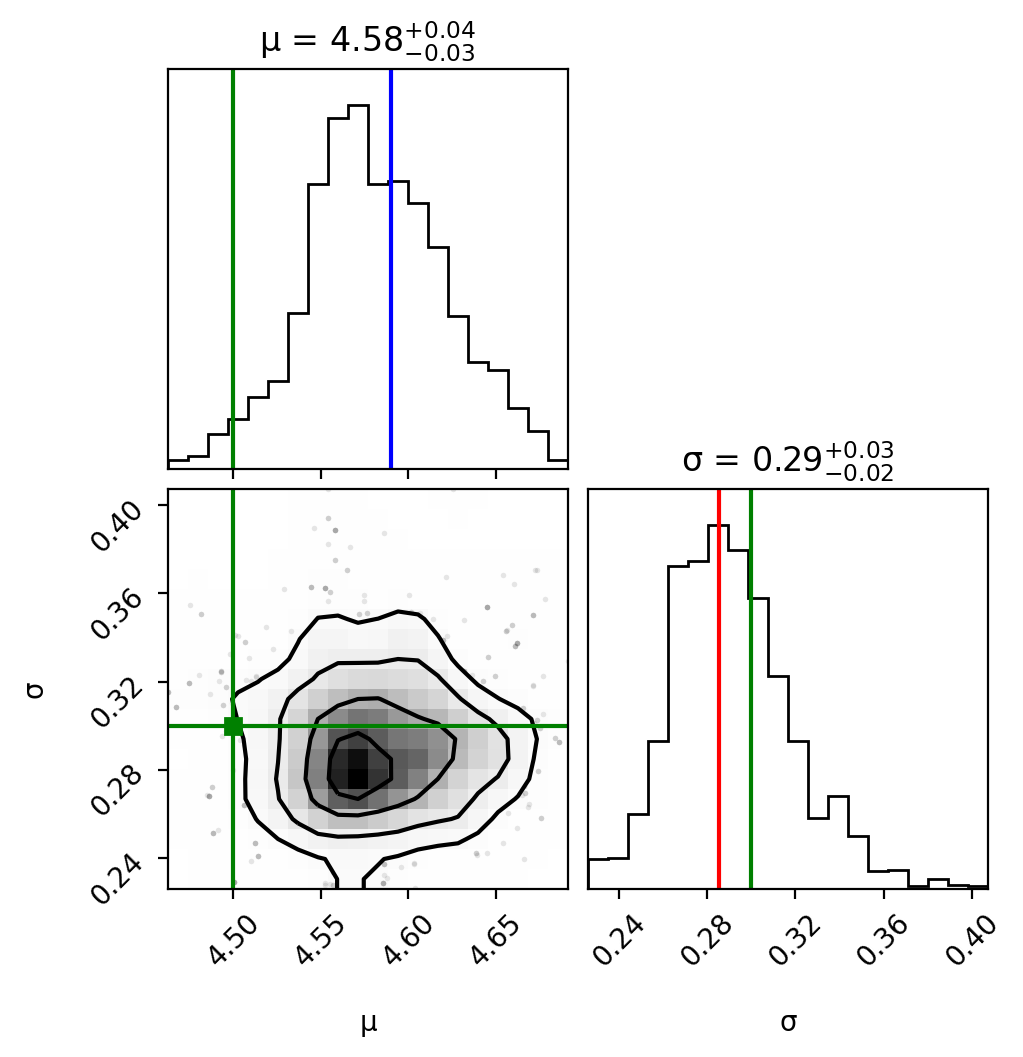

In [17]:
sample = sampler.chain[:, 75:, :].reshape(-1, 2)
fig = corner(sample, truths=θ, truth_color='green', smooth=True, labels=['μ', 'σ'], show_titles=True) # quantiles=[0.025, 0.5, 0.975], 
fig.axes[0].axvline(X.mean(), color='blue')
fig.axes[3].axvline(X.std(ddof=1), color='red');

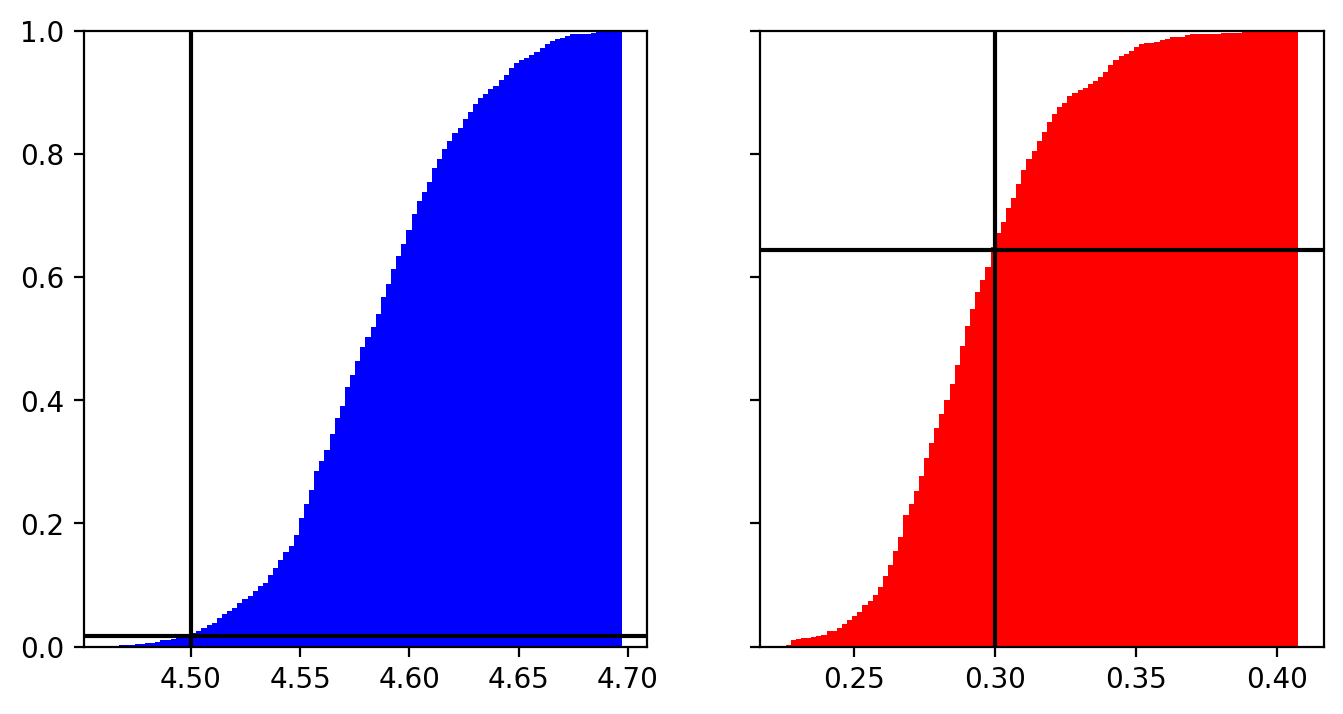

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
sample = sampler.chain[:, 50:, :].reshape(-1, 2)
for i, ax in enumerate(axes):
    ax.hist(sample[:, i], bins=100, cumulative=True, density=True, color=['blue', 'red'][i])
    ax.axvline(θ[i], color='k')
    ax.set(ylim=(0,1))
    ax.axhline((sample[:,i] < θ[i]).mean(), color='k')

In [19]:
inv_cdf_θ = np.array([inv_cdf(fit(X), θ) for _ in range(100)])

/Users/yoavram/miniconda3/envs/scipy/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


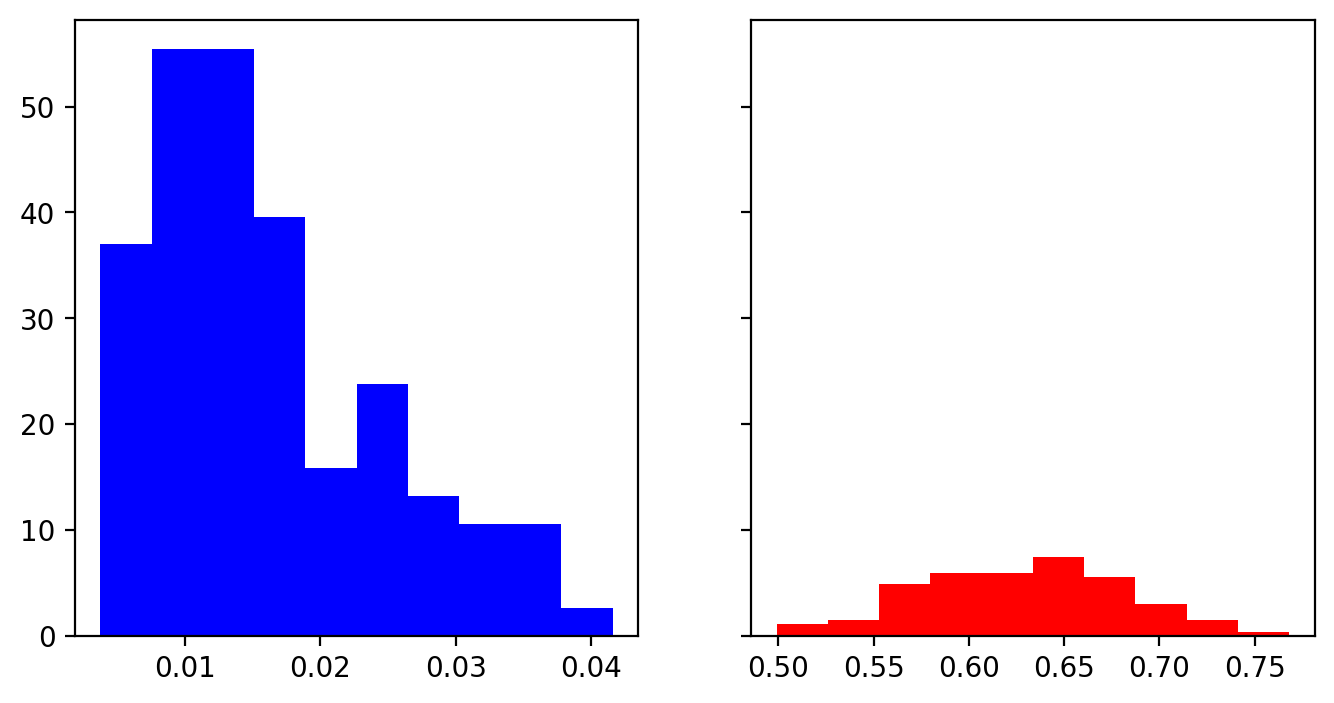

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
for i, ax in enumerate(axes):
    ax.hist(inv_cdf_θ[:,i], bins=10, density=True, color=['blue', 'red'][i])